**Recopiez ce notebook et envoyez-moi le lien à la fin de la séance.**

Votre **nom**:PHAM


Votre **prénom**: Duc Thinh


*Observations/commentaires éventuels de l'étudiant à l'enseignant*:



# MLP Neural Networks for 2d classification

This notebook will show you how to use **PyTorch** to build simple neural network.
We will use these networks to classify points from 2 classes in the plane (2 dimensions).


We start with a linear model, then a fully connected MLP with two hidden layers:
 * input retina with 2 neurons ($(x,y)$)
 * a linear layer + ReLu with N1 neurons
 * another one with N2 neurons
 * output layer, with one neuron per class.
 
As it is a classification problem, we will use the cross-entropy cost function (`CrossEntropyLoss`).

Please note that in order to keep the code simple, we use all the available data for training, and don't use any evaluation/test sets (this a _bad_ practice, but we're just playing here !).

*Emmanuel Viennet, 2019-12-15, 2021-01-03, 2022-01-11*

# Initialization and Helper functions

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams["figure.figsize"] = (12, 8) # (w, h)
from collections import OrderedDict
import copy

import sklearn, sklearn.datasets # used to generate a dataset

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def plot_data(X, y, figsize=None, newfig=True):
    "A simple data plot"
    if newfig:
        plt.figure(figsize=figsize)
    plt.plot(X[y!=1, 0], X[y!=1, 1], 'or', alpha=0.9, label=0, markersize=8)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.9, label=1, markersize=9)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def subplot_2d_model(ax, X, y, model, subtitle="", step=0.001):
    """Plot data and model output classes"""
    if subtitle:
        ax.set_title(subtitle)
    # use a mesh grid
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Generates a meshgrid and apply the model on each point of the grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    Xgrid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    Ygrid = model(Xgrid).detach().numpy()
    # The class is given by the max output
    Ygrid_class = np.argmax(Ygrid, axis=1).reshape(xx.shape)
    
    # Display points of the mesh
    plt.imshow(Ygrid_class, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Set3_r,
           aspect='auto', origin='lower')
    # Add the sample points (training set):
    plot_data(X, y, newfig=False)
    
def plot_2d_model(X, y, model, title="", step=0.001):
    """Display the sample and the classes computed by the NN model"""
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot( 111 )
    subplot_2d_model(ax, X, y, model, step=step)
    plt.title(title)
    return plt

### Confusion Matrix (for classification)
The confusion matrix allows to count the distinct types of errors of a classifier.
The cell $(i, j)$ gives the number of examples from class $i$ classified by the model in class $j$.


In [3]:
def confusion_matrix( y, y_pred ):     #sổ bảng các phần tử có giá trị khác giữa real và predict
    """Confusion matrix
    CM[b,c] = number of example from class b classified by the model in class c
    """
    # y et y_pred are vectors containing the index of classes (0, .., nbClass)
    NbClass = len(np.unique(y)) # number of classes
    CM = np.zeros((NbClass,NbClass))
    # The predicted class is given by the max of the output
    for i in range(len(x_data)):
        real_class = y[i]
        pred_class = np.argmax(y_pred[i])      # trả về index của max
        #print("real", real_class, "predicted", pred_class)
        CM[real_class, pred_class] += 1                    #purpose: cộng giá trị váo đường chéo
    return CM

# Setup data

Number of examples 100
X.mean =  [0.51339765 0.49191772]
Number of classes: 2
min(y)= 0 max(y)= 1


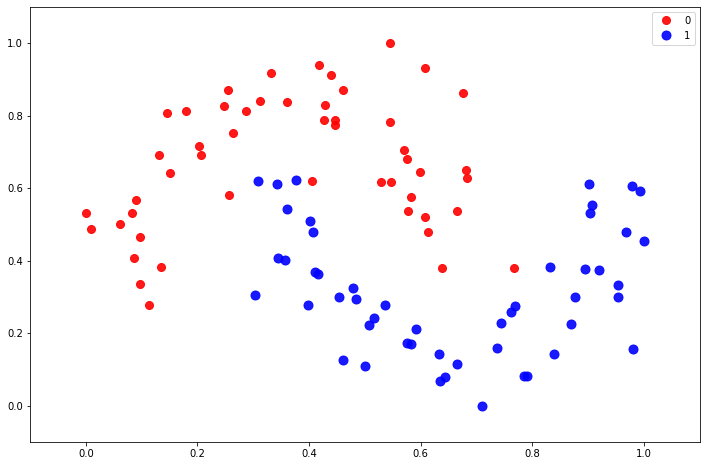

In [4]:
X, y = sklearn.datasets.make_moons(n_samples=100, shuffle=True, noise=0.2, random_state=0)
# X[:,0] = (X[:,0]+1)/3 - 0.5
X = (X - X.min(axis=0)) / (X.max(axis=0)-X.min(axis=0))
N = X.shape[0]
print("Number of examples", N)
print("X.mean = ", X.mean(axis=0))
NbClass = len(np.unique(y)) # number of distinct classes
print("Number of classes:", NbClass)
print("min(y)=", min(y), "max(y)=", max(y))

# Display data
plot_data(X,y, figsize=(12,8))

In [5]:
NbClass

2

In [6]:
X

array([[0.35990046, 0.83776767],
       [0.95393632, 0.33287715],
       [0.63909707, 0.38014293],
       [0.35724712, 0.40061025],
       [0.63252873, 0.14246251],
       [0.97897095, 0.60529188],
       [0.5291048 , 0.61769586],
       [0.6442571 , 0.07772523],
       [0.36061065, 0.54156242],
       [0.9035326 , 0.53172221],
       [0.30921891, 0.61880081],
       [0.95447302, 0.29932854],
       [0.78581566, 0.08290439],
       [0.67576293, 0.86326871],
       [0.5469006 , 0.61737816],
       [0.25525221, 0.86965419],
       [0.43946002, 0.9117923 ],
       [0.42730748, 0.78847465],
       [0.26383819, 0.75265022],
       [0.68326906, 0.62786316],
       [0.15091032, 0.64211591],
       [0.4841675 , 0.2941593 ],
       [0.59844385, 0.64321268],
       [0.58215122, 0.17080269],
       [0.13465356, 0.38295708],
       [0.11385503, 0.27644367],
       [0.57722988, 0.53670508],
       [1.        , 0.45319802],
       [0.89385089, 0.37738804],
       [0.76982038, 0.27585296],
       [0.

In [7]:
y

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0])

In [8]:
# Data formating
# from_numpy converts a Numpy array to a Tensor.
print("X.dtype=", X.dtype)
x_data = torch.Tensor(X)
y_data = torch.from_numpy(y)
# Have a look at the data types:
print("y.dtype=", y.dtype)
print("y_data.dtype=", y_data.dtype)
print("x_data.dtype=", x_data.dtype)

X.dtype= float64
y.dtype= int64
y_data.dtype= torch.int64
x_data.dtype= torch.float32


Note that PyTorch uses `float32` type for input tensors, in order to reduce memory footprint and accelerate computations.

# A Linear Model

This model is a neural network with one linear layer (`nn.Linear`) with `NbClass`output cells
(no hideen layers). Each output cell thus computes a dot product between the input and its weights.

The class is given by the most active output cell.

In PyTorch, you just need to define the `__init__` function which is bluilding the network (defining its architecture), and a `forward` function, which computes the output given the input. The gradients are automatically computed !

In [9]:
class LinearNNModel(nn.Module):
    def __init__(self):
        super(LinearNNModel, self).__init__()
        self.linear_layer = nn.Linear(2, NbClass)
    
    def forward(self, x):
        x = self.linear_layer(x)
        return x

model = LinearNNModel()

In [10]:
# The criteria to optmize (cost)
criterion = nn.CrossEntropyLoss()

PyTorch proposes several opmization algorithms. SGD is a good starting choice. We specify the learning rate (lr) and a momentum (an opmization trick stabilizing the convergence).


In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)     # momentum là momen hướng của giá trị 

0.5628262162208557


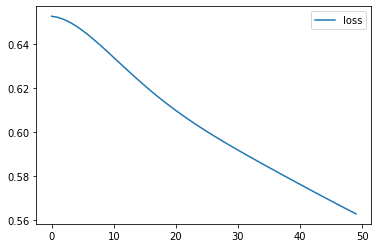

In [12]:
# Learning loop
batch_size = 100
num_epochs = 50

losses = []
for epoch in range(num_epochs):
    for beg_i in range(0, x_data.size(0), batch_size):
        x_batch = x_data[ beg_i:beg_i + batch_size, :]
        y_batch = y_data[ beg_i:beg_i + batch_size]
        # reset gradients to zero:
        optimizer.zero_grad()
        # forward:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        # backpropagation
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

plt.plot(losses, label="loss")
plt.legend()
print(losses[-1])

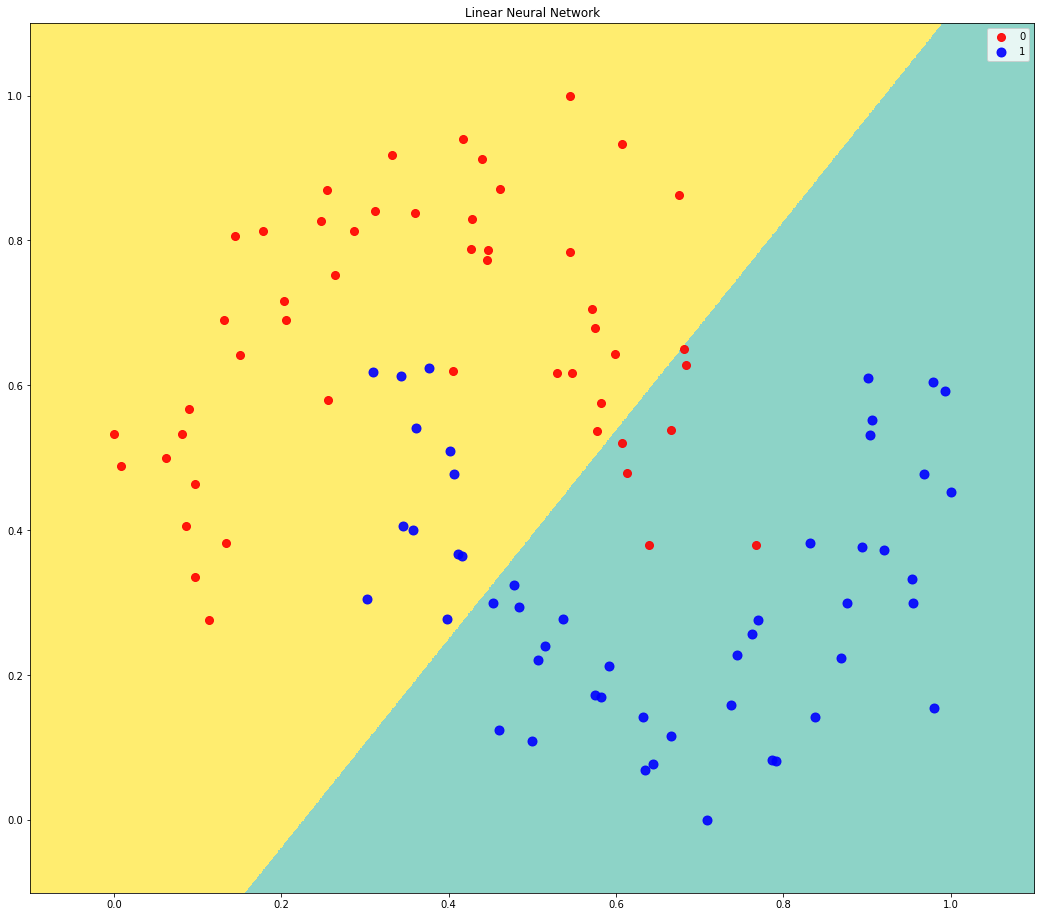

In [13]:
jnk=plot_2d_model(X, y, model, "Linear Neural Network")

In [14]:
# Computes network outputs and convert them back to a NumPy array
y_pred = model(x_data).detach().numpy()

CM = confusion_matrix(y, y_pred)
print(CM)

[[43.  7.]
 [12. 38.]]


# Questions:

Write simple code to answer the following questions:


- How many examples are missclassified ? 
- What is the error rate in percent ?


In [15]:
y

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0])

In [16]:
y_pred

array([[ 5.7524508e-01,  5.1445983e-02],
       [-1.8749934e-01,  3.9368138e-01],
       [ 8.2490116e-02,  2.5697270e-01],
       [ 3.1087700e-01,  1.3901830e-01],
       [-5.7318926e-02,  3.0251572e-01],
       [-4.0669709e-02,  3.4855142e-01],
       [ 3.1151399e-01,  1.6439122e-01],
       [-1.0575402e-01,  3.2037830e-01],
       [ 3.9419562e-01,  1.1179513e-01],
       [-2.7712256e-02,  3.3300921e-01],
       [ 4.8063332e-01,  7.5382546e-02],
       [-2.0835471e-01,  4.0070084e-01],
       [-2.1104032e-01,  3.7648600e-01],
       [ 3.4881538e-01,  1.7381269e-01],
       [ 2.9768777e-01,  1.7164111e-01],
       [ 6.7484343e-01,  2.7258396e-03],
       [ 5.5940765e-01,  6.8560012e-02],
       [ 4.9356839e-01,  8.8658594e-02],
       [ 5.9696460e-01,  2.9917881e-02],
       [ 1.9961065e-01,  2.2457737e-01],
       [ 6.1611539e-01,  6.7336932e-03],
       [ 1.4877780e-01,  2.1185103e-01],
       [ 2.7394584e-01,  1.8721452e-01],
       [-1.4563799e-03,  2.7642789e-01],
       [ 4.70639

In [17]:
y_pred_class = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
y_pred_class[2], y[2]

(1, 0)

In [18]:
np.where(y_pred_class!=y)

(array([ 2,  3,  8, 10, 19, 34, 37, 38, 40, 44, 49, 51, 52, 55, 59, 63, 85,
        86, 94]),)

In [19]:
len(np.where(y_pred_class!=y)[0])

19

In [20]:
error_rate = (len(np.where(y_pred_class!=y)[0]))/(len(y))
error_rate

0.19

- What is the last measured value of the cost ? R: Please refer the result below 
- Did the learning converged ? R: No
- Should we use more epochs ? R: Yes

In [21]:
print(losses[-1])  #What is the last measured value of the cost ?

0.5628262162208557


0.5028684735298157


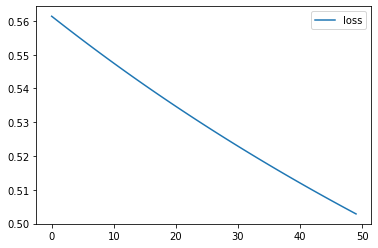

In [22]:
#Did the learning converged ? R: Did not converge
# Learning loop
batch_size = 100
num_epochs = 50

losses = []
for epoch in range(num_epochs):
    for beg_i in range(0, x_data.size(0), batch_size):
        x_batch = x_data[ beg_i:beg_i + batch_size, :]
        y_batch = y_data[ beg_i:beg_i + batch_size]
        # reset gradients to zero:
        optimizer.zero_grad()
        # forward:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        # backpropagation
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

plt.plot(losses, label="loss")
plt.legend()
print(losses[-1])

0.3037456274032593


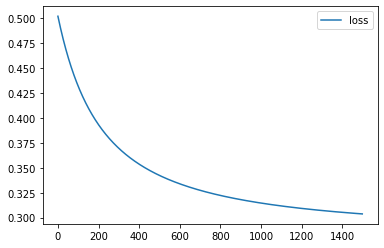

In [23]:
# Should we use more epochs ? Yes
# Learning loop
batch_size = 100
num_epochs = 1500

losses = []
for epoch in range(num_epochs):
    for beg_i in range(0, x_data.size(0), batch_size):
        x_batch = x_data[ beg_i:beg_i + batch_size, :]
        y_batch = y_data[ beg_i:beg_i + batch_size]
        # reset gradients to zero:
        optimizer.zero_grad()
        # forward:
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        # backpropagation
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

plt.plot(losses, label="loss")
plt.legend()
print(losses[-1])

If we run more epochs, how evolves the cost ? Do the confusion matrix enhances ?
R: The cost decrease. Yes the confusion matrix enhances

In [24]:
# Computes network outputs and convert them back to a NumPy array
y_pred = model(x_data).detach().numpy()

CM_1 = confusion_matrix(y, y_pred)
print(CM_1)

[[45.  5.]
 [ 8. 42.]]


## A fully connected neural network

Our second model is a neural network with three hidden layers, and ReLu activation functions.

The number of neurons per layer is:

`2 -> N1 -> N2 -> NbClass`

You can change `N1`, `N2` below.


The `__init__` constructor creates 3 fully connected linear layers (fc1, fc2, ..., "fc" meaning "fully connected", used by the `forward` method. 

In [25]:
# The Neural Network model:
class Net2(nn.Module):
    def __init__(self, N1=5, N2=5):
        "Build fully connected NN with 2 hidden layers"""
        super(Net2, self).__init__()
        self.N1, self.N2 = N1, N2
        self.fc1 = nn.Linear(2, N1)
        self.fc2 = nn.Linear(N1, N2)
        self.fc3 = nn.Linear(N2, NbClass)

    def forward(self, x):
        x = F.relu(self.fc1(x))                 # max (x,0); activation function
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [26]:
# Create network and optimizer:

torch.manual_seed(12345678) # for reproducibility
net = Net2(N1=5, N2=5)
# The criteria to optimize (cost function)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(), 0.008)

# Etonnants sauts !
# optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.3)

# Le meilleur trouvé:
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.1)



#### Learning the Neural Network


0001	0.691026
0011	0.303859
0021	0.294253
0031	0.288343
0041	0.28486
0051	0.281245
0061	0.280003
0071	0.279463
0081	0.278268
0091	0.278864
0101	0.278051
no more changes: stopping !
0.2781454920768738


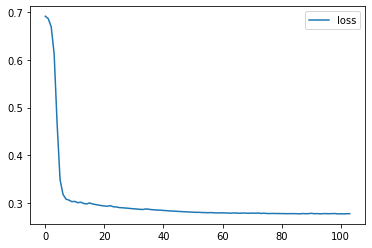

In [27]:
# Learning (without mini-batch)

min_nb_epochs = 100
max_nb_epochs = 3000

# Stop criteria: no average on window did not change more than min_change
window_size=10
min_change=1e-4

losses = []
models_states = OrderedDict()
for epoch in range(max_nb_epochs):
    for i in range(x_data.size(0)):
        x_i = x_data[ i:i + 1, :]
        y_i = y_data[ i:i + 1]
        # reset gradients to zero
        optimizer.zero_grad()
        # forward:
        outputs = net(x_i)
        loss = criterion(outputs, y_i)
        # backpropagation:
        loss.backward()
        optimizer.step()
    # After epoch, computes average loss on training set
    train_outputs = net(x_data)
    train_loss = criterion(train_outputs, y_data)
    losses.append(train_loss.data.item()) # record cost (loss) after each epoch
    models_states[len(losses)] = copy.deepcopy(net.state_dict())
    if len(losses) % window_size == 1:
        print("%04d\t%g" %(len(losses), losses[-1]) )
        
    # Should we stop ?
    if len(losses) > min_nb_epochs:
        last_avg_loss = np.mean(losses[-window_size:])
        before_avg_loss = np.mean(losses[-2*window_size:-window_size])
        if abs(last_avg_loss-before_avg_loss) < min_change:
            print("no more changes: stopping !")
            break

plt.plot(losses, label="loss")
plt.legend()
print(losses[-1])




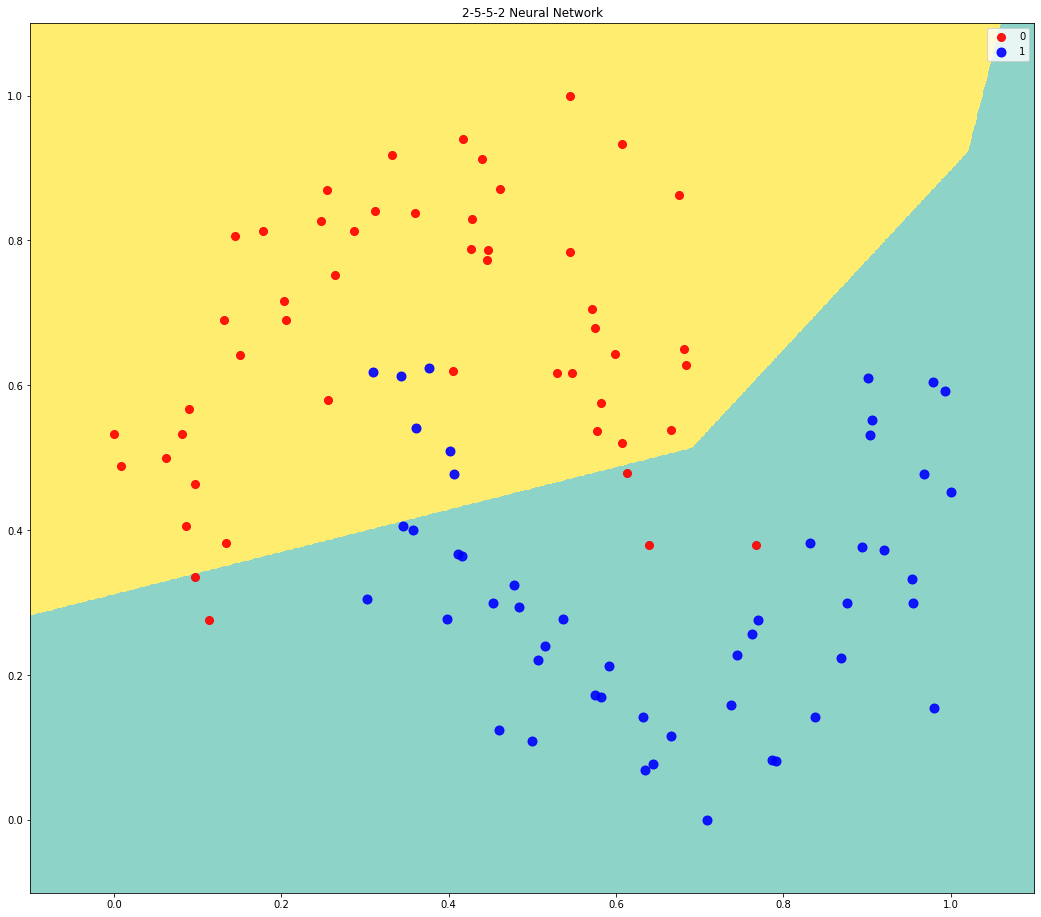

In [28]:
jnk=plot_2d_model(X, y, net, "2-{}-{}-2 Neural Network".format(net.N1,net.N2))

0001	0.27802
0011	0.277846
0021	0.277531
0031	0.277309
0041	0.276799
0051	0.276129
0061	0.276026
0071	0.275325
0081	0.276341
0091	0.27558
0101	0.274658
0111	0.274288
0121	0.275182
0131	0.271723
0141	0.271022
0151	0.274536
0161	0.273303
0171	0.274247
0181	0.273787
0191	0.27455
0201	0.274554
0211	0.271485
0221	0.275513
0231	0.270799
0241	0.273268
0251	0.273829
0261	0.265946
0271	0.272026
0281	0.273453
0291	0.270503
0301	0.270471
0311	0.272403
0321	0.270543
0331	0.269407
0341	0.269058
0351	0.269823
0361	0.262891
0371	0.262363
0381	0.262004
0391	0.266591
0401	0.263806
0411	0.258509
0421	0.271397
0431	0.271118
0441	0.270859
0451	0.272463
0461	0.260758
0471	0.263187
0481	0.268043
0491	0.270817
0501	0.264625
0511	0.26232
0521	0.266415
0531	0.265367
0541	0.259547
0551	0.258123
0561	0.262213
0571	0.264321
0581	0.263892
0591	0.260068
0601	0.25603
0611	0.263791
0621	0.262274
0631	0.262543
0641	0.262412
0651	0.262022
0661	0.259099
0671	0.247096
0681	0.215919
0691	0.148487
0701	0.115579
0711	0.0741

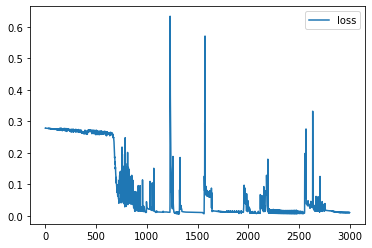

In [29]:
# Learning (without mini-batch)

min_nb_epochs = 100
max_nb_epochs = 3000

# Stop criteria: no average on window did not change more than min_change
window_size=10
min_change=1e-4

losses = []
models_states = OrderedDict()
for epoch in range(max_nb_epochs):
    for i in range(x_data.size(0)):
        x_i = x_data[ i:i + 1, :]
        y_i = y_data[ i:i + 1]
        # reset gradients to zero
        optimizer.zero_grad()
        # forward:
        outputs = net(x_i)
        loss = criterion(outputs, y_i)
        # backpropagation:
        loss.backward()
        optimizer.step()
    # After epoch, computes average loss on training set
    train_outputs = net(x_data)
    train_loss = criterion(train_outputs, y_data)
    losses.append(train_loss.data.item()) # record cost (loss) after each epoch
    models_states[len(losses)] = copy.deepcopy(net.state_dict())
    if len(losses) % window_size == 1:
        print("%04d\t%g" %(len(losses), losses[-1]) )
        
    # # Should we stop ?
    # if len(losses) > min_nb_epochs:
    #     last_avg_loss = np.mean(losses[-window_size:])
    #     before_avg_loss = np.mean(losses[-2*window_size:-window_size])
    #     if abs(last_avg_loss-before_avg_loss) < min_change:
    #         print("no more changes: stopping !")
    #         break

plt.plot(losses, label="loss")
plt.legend()
print(losses[-1])

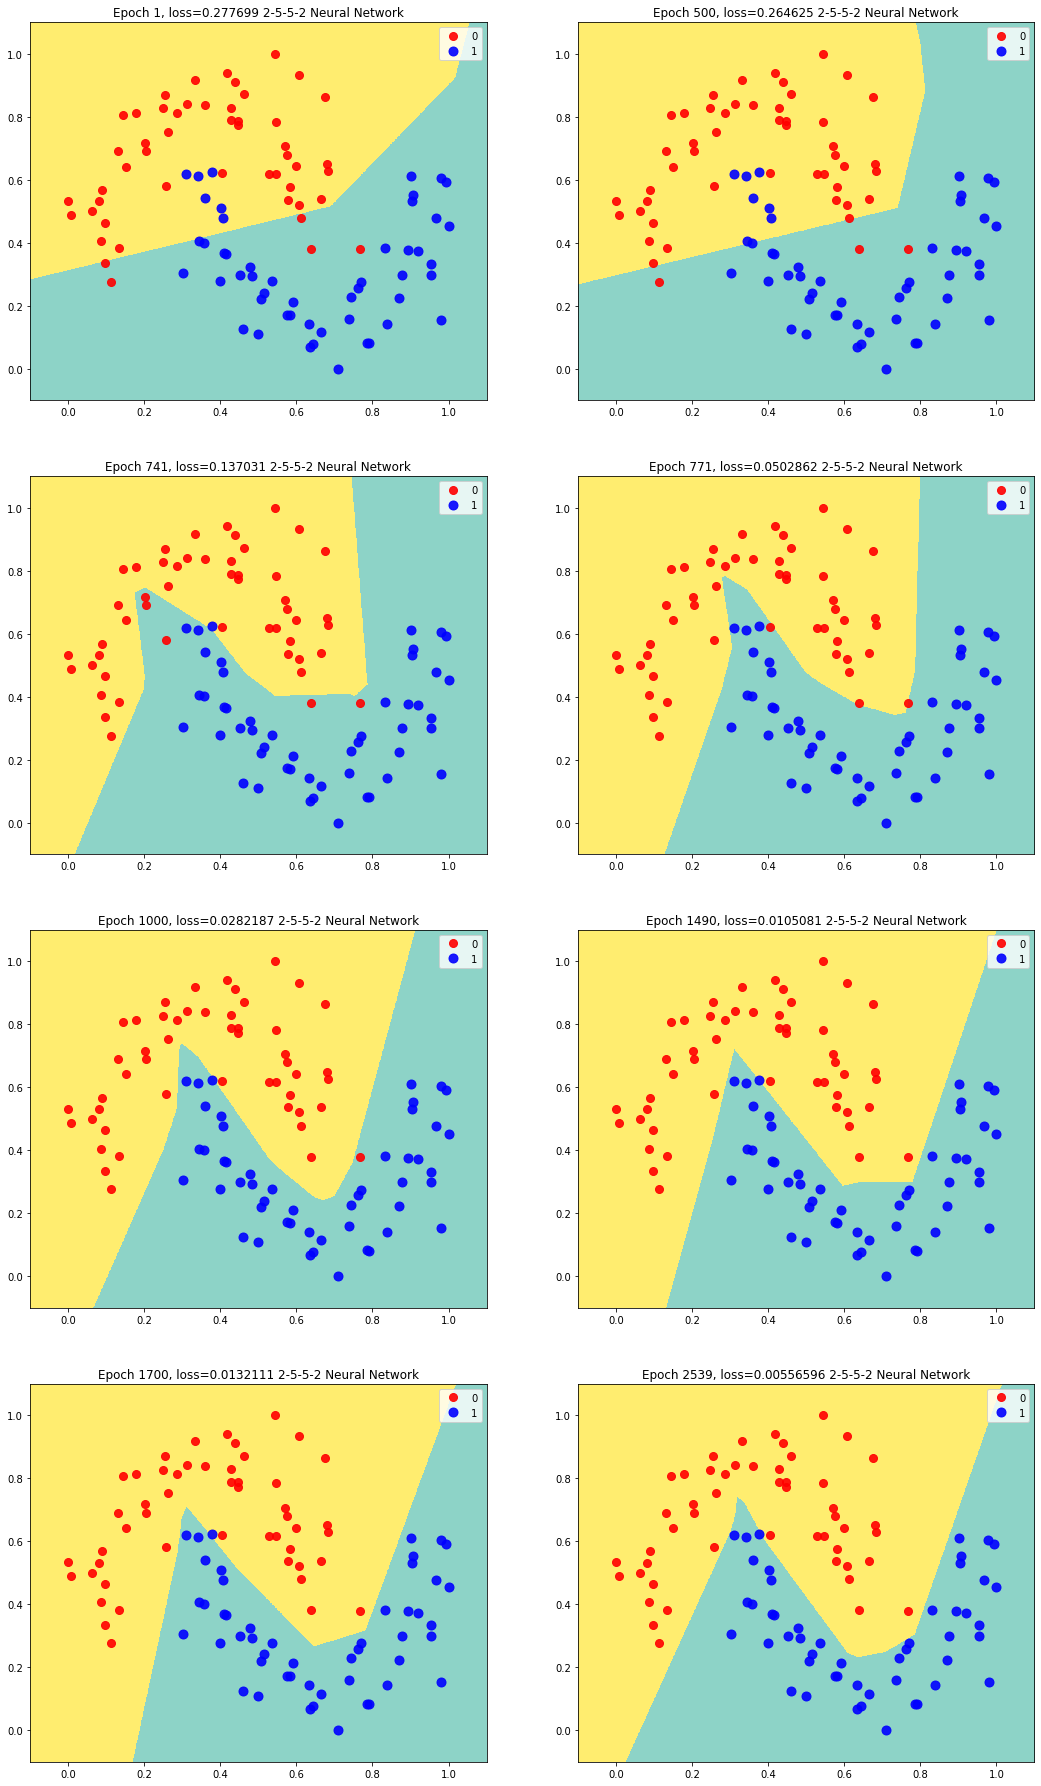

In [30]:
# Pick *best* model
best_epoch = np.argmin(losses)

ages = [ 1, 500, 741, 771, 1000, 1490, 1700, best_epoch]

fig = plt.figure(figsize=(18, 32))
spec = gridspec.GridSpec(ncols=2, nrows=4, width_ratios=[1,1], height_ratios=[2,2,2,2])

for i, age in enumerate(ages):
    age_state = models_states[age]
    net.load_state_dict(age_state)
    tit = "Epoch {}, loss={:g} 2-{}-{}-2 Neural Network".format(age, losses[age], net.N1,net.N2)
    ax = fig.add_subplot( spec[i] )
    subplot_2d_model(ax, X, y, net, subtitle=tit)
    

In [31]:
# Les poids
#net = Net(N1=5, N2=5, N3=5)
net.fc2.weight.data


tensor([[-0.2053,  3.2194,  0.1688,  0.2224, -0.0795],
        [ 0.7892,  0.4254, -2.7844, -0.1656,  0.0336],
        [-0.3311,  2.5279, -7.2222,  0.1785,  0.1106],
        [ 6.8117,  1.7718, -0.5366,  0.1923,  0.3582],
        [-5.8255, -4.2769,  2.2688, -0.3966,  0.3961]])

In [32]:
# This is the output of the network at x=(0,0)
net(torch.tensor( (0,0), dtype=torch.float32 ))

tensor([ -2.1741, -22.3708], grad_fn=<AddBackward0>)

In [33]:
# Confusion matrix
# note that we need to convert the tensor back to a standard array:
y_pred = net(x_data).detach().numpy()

CM = confusion_matrix(y, y_pred)
print(CM)

[[50.  0.]
 [ 0. 50.]]


# Questions
Answer writing code and explanations.

- How many examples are missclassified ? R: 0
- What is the error rate in percent ? R: 0

- Try different learning rates and observe the convergence: is it sensitive to the rate value ? R: Yes it is sensitive. While the learning rate is higher, the convergence is faster => over-fit. While the learning rate is lower, the convergence is slower. 

In [34]:
print(len(np.where(y_pred_class!=y)[0]))
error_rate = (len(np.where(y_pred_class!=y)[0]))/(len(y))
error_rate

19


0.19

0001	0.00556596
0011	0.00777226
0021	0.0778306
0031	0.275284
0041	0.0354635
0051	0.035471
0061	0.0303103
0071	0.0353007
0081	0.0354845
0091	0.0280147
0101	0.0734742
0111	0.06492
0121	0.0615805
0131	0.123065
0141	0.0638423
0151	0.0314419
0161	0.0296331
0171	0.0437955
0181	0.0249821
0191	0.0199302
0201	0.0165978
0211	0.0231641
0221	0.016335
0231	0.0147719
0241	0.0828739
0251	0.0341542
0261	0.0211135
0271	0.0224357
0281	0.0177251
0291	0.0147081
0301	0.012443
0311	0.0148179
0321	0.0161217
0331	0.0974438
0341	0.00983463
0351	0.00836381
0361	0.00794664
0371	0.00784808
0381	0.00769139
0391	0.00791448
0401	0.0081972
0411	0.00776268
0421	0.00803931
0431	0.0124037
0441	0.00812546
0451	0.00794677
0461	0.00819851
0471	0.00859559
0481	0.00893882
0491	0.00827872
0501	0.00820901
0511	0.114711
0521	0.0795904
0531	0.0431451
0541	0.0426323
0551	0.0371623
0561	0.0313906
0571	0.0219517
0581	0.0161216
0591	0.0152746
0601	0.015206
0611	0.0146597
0621	0.0144716
0631	0.0145309
0641	0.0196349
0651	0.00631306
0

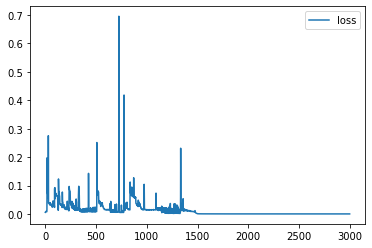

In [35]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.1)
# Learning (without mini-batch)

min_nb_epochs = 100
max_nb_epochs = 3000

# Stop criteria: no average on window did not change more than min_change
window_size=10
min_change=1e-4

losses = []
models_states = OrderedDict()
for epoch in range(max_nb_epochs):
    for i in range(x_data.size(0)):
        x_i = x_data[ i:i + 1, :]
        y_i = y_data[ i:i + 1]
        # reset gradients to zero
        optimizer.zero_grad()
        # forward:
        outputs = net(x_i)
        loss = criterion(outputs, y_i)
        # backpropagation:
        loss.backward()
        optimizer.step()
    # After epoch, computes average loss on training set
    train_outputs = net(x_data)
    train_loss = criterion(train_outputs, y_data)
    losses.append(train_loss.data.item()) # record cost (loss) after each epoch
    models_states[len(losses)] = copy.deepcopy(net.state_dict())
    if len(losses) % window_size == 1:
        print("%04d\t%g" %(len(losses), losses[-1]) )
        
    # # Should we stop ?
    # if len(losses) > min_nb_epochs:
    #     last_avg_loss = np.mean(losses[-window_size:])
    #     before_avg_loss = np.mean(losses[-2*window_size:-window_size])
    #     if abs(last_avg_loss-before_avg_loss) < min_change:
    #         print("no more changes: stopping !")
    #         break

plt.plot(losses, label="loss")
plt.legend()
print(losses[-1])

0001	2.04513e-05
0011	2.04441e-05
0021	2.0437e-05
0031	2.04334e-05
0041	2.04251e-05
0051	2.04203e-05
0061	2.04144e-05
0071	2.04096e-05
0081	2.04037e-05
0091	2.03989e-05
0101	2.03929e-05
0111	2.0387e-05
0121	2.03822e-05
0131	2.03751e-05
0141	2.03703e-05
0151	2.03644e-05
0161	2.03608e-05
0171	2.03536e-05
0181	2.03489e-05
0191	2.03441e-05
0201	2.03405e-05
0211	2.03334e-05
0221	2.03286e-05
0231	2.03239e-05
0241	2.03203e-05
0251	2.03143e-05
0261	2.03108e-05
0271	2.03048e-05
0281	2.03e-05
0291	2.02965e-05
0301	2.02929e-05
0311	2.02858e-05
0321	2.02822e-05
0331	2.02762e-05
0341	2.02715e-05
0351	2.02667e-05
0361	2.02631e-05
0371	2.02572e-05
0381	2.02524e-05
0391	2.02488e-05
0401	2.02441e-05
0411	2.02393e-05
0421	2.02345e-05
0431	2.02298e-05
0441	2.0225e-05
0451	2.02191e-05
0461	2.02131e-05
0471	2.02083e-05
0481	2.02036e-05
0491	2.01988e-05
0501	2.01928e-05
0511	2.01881e-05
0521	2.01833e-05
0531	2.01786e-05
0541	2.01738e-05
0551	2.0169e-05
0561	2.01631e-05
0571	2.01571e-05
0581	2.01524e-05
0591

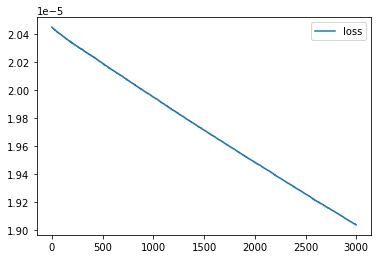

In [36]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.002, momentum=0.1)
# Learning (without mini-batch)

min_nb_epochs = 100
max_nb_epochs = 3000

# Stop criteria: no average on window did not change more than min_change
window_size=10
min_change=1e-4

losses = []
models_states = OrderedDict()
for epoch in range(max_nb_epochs):
    for i in range(x_data.size(0)):
        x_i = x_data[ i:i + 1, :]
        y_i = y_data[ i:i + 1]
        # reset gradients to zero
        optimizer.zero_grad()
        # forward:
        outputs = net(x_i)
        loss = criterion(outputs, y_i)
        # backpropagation:
        loss.backward()
        optimizer.step()
    # After epoch, computes average loss on training set
    train_outputs = net(x_data)
    train_loss = criterion(train_outputs, y_data)
    losses.append(train_loss.data.item()) # record cost (loss) after each epoch
    models_states[len(losses)] = copy.deepcopy(net.state_dict())
    if len(losses) % window_size == 1:
        print("%04d\t%g" %(len(losses), losses[-1]) )
        
    # # Should we stop ?
    # if len(losses) > min_nb_epochs:
    #     last_avg_loss = np.mean(losses[-window_size:])
    #     before_avg_loss = np.mean(losses[-2*window_size:-window_size])
    #     if abs(last_avg_loss-before_avg_loss) < min_change:
    #         print("no more changes: stopping !")
    #         break

plt.plot(losses, label="loss")
plt.legend()
print(losses[-1])

0001	1.90243e-05
0011	1.87646e-05
0021	1.84108e-05
0031	1.80666e-05
0041	1.77378e-05
0051	1.74221e-05
0061	1.7116e-05
0071	1.68205e-05
0081	1.65358e-05
0091	1.62607e-05
0101	1.59962e-05
0111	1.57365e-05
0121	1.54899e-05
0131	1.52457e-05
0141	1.50146e-05
0151	1.47882e-05
0161	1.45678e-05
0171	1.43534e-05
0181	1.4146e-05
0191	1.39459e-05
0201	1.37505e-05
0211	1.35611e-05
0221	1.33764e-05
0231	1.31965e-05
0241	1.30225e-05
0251	1.28498e-05
0261	1.26854e-05
0271	1.25257e-05
0281	1.23672e-05
0291	1.22147e-05
0301	1.20634e-05
0311	1.19169e-05
0321	1.17775e-05
0331	1.16357e-05
0341	1.14986e-05
0351	1.13676e-05
0361	1.12389e-05
0371	1.11102e-05
0381	1.09851e-05
0391	1.08897e-05
0401	1.08016e-05
0411	1.06896e-05
0421	1.05621e-05
0431	1.04417e-05
0441	1.03285e-05
0451	1.02189e-05
0461	1.0226e-05
0471	1.0058e-05
0481	9.93291e-06
0491	9.83282e-06
0501	9.79585e-06
0511	9.65407e-06
0521	9.65045e-06
0531	9.48605e-06
0541	9.39073e-06
0551	9.32875e-06
0561	9.21317e-06
0571	9.18216e-06
0581	9.05706e-06
0

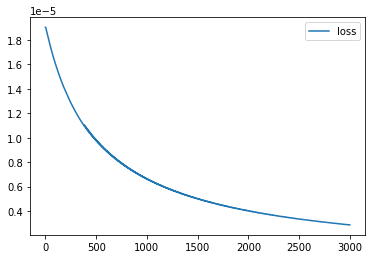

In [37]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.15, momentum=0.1)
# Learning (without mini-batch)

min_nb_epochs = 100
max_nb_epochs = 3000

# Stop criteria: no average on window did not change more than min_change
window_size=10
min_change=1e-4

losses = []
models_states = OrderedDict()
for epoch in range(max_nb_epochs):
    for i in range(x_data.size(0)):
        x_i = x_data[ i:i + 1, :]
        y_i = y_data[ i:i + 1]
        # reset gradients to zero
        optimizer.zero_grad()
        # forward:
        outputs = net(x_i)
        loss = criterion(outputs, y_i)
        # backpropagation:
        loss.backward()
        optimizer.step()
    # After epoch, computes average loss on training set
    train_outputs = net(x_data)
    train_loss = criterion(train_outputs, y_data)
    losses.append(train_loss.data.item()) # record cost (loss) after each epoch
    models_states[len(losses)] = copy.deepcopy(net.state_dict())
    if len(losses) % window_size == 1:
        print("%04d\t%g" %(len(losses), losses[-1]) )
        
    # # Should we stop ?
    # if len(losses) > min_nb_epochs:
    #     last_avg_loss = np.mean(losses[-window_size:])
    #     before_avg_loss = np.mean(losses[-2*window_size:-window_size])
    #     if abs(last_avg_loss-before_avg_loss) < min_change:
    #         print("no more changes: stopping !")
    #         break

plt.plot(losses, label="loss")
plt.legend()
print(losses[-1])

- Try to enhance the neural network model: change `N1`, `N2`: for each values, record the value of the cost, the number of errors and the error rate. What is your optimal architecture ? Refer the result below, N1 = 6 and N2 = 2 

In [76]:
# Create network and optimizer:
def network_opt(N1_=5,N2_=5,min_nb_epochs_=100,max_nb_epochs_=3000,lr_=0.05,momentum_=0.1,stop=True):
  torch.manual_seed(12345678) # for reproducibility
  net = Net2(N1=N1_, N2=N2_)
  # The criteria to optimize (cost function)
  criterion = nn.CrossEntropyLoss()
  #optimizer = torch.optim.Adam(net.parameters(), 0.008)

  # Etonnants sauts !
  # optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.3)

  # Le meilleur trouvé:
  optimizer = torch.optim.SGD(net.parameters(), lr=lr_, momentum=momentum_)
  # Learning (without mini-batch)

  min_nb_epochs = min_nb_epochs_
  max_nb_epochs = max_nb_epochs_

  # Stop criteria: no average on window did not change more than min_change
  window_size=10
  min_change=1e-4

  losses = []
  models_states = OrderedDict()
  for epoch in range(max_nb_epochs):
      for i in range(x_data.size(0)):
          x_i = x_data[ i:i + 1, :]
          y_i = y_data[ i:i + 1]
          # reset gradients to zero
          optimizer.zero_grad()
          # forward:
          outputs = net(x_i)
          loss = criterion(outputs, y_i)
          # backpropagation:
          loss.backward()
          optimizer.step()
      # After epoch, computes average loss on training set
      train_outputs = net(x_data)
      train_loss = criterion(train_outputs, y_data)
      losses.append(train_loss.data.item()) # record cost (loss) after each epoch
      models_states[len(losses)] = copy.deepcopy(net.state_dict())
      # if len(losses) % window_size == 1:
      #     print("%04d\t%g" %(len(losses), losses[-1]) )
          
      # Should we stop ?
      if (stop):
        if len(losses) > min_nb_epochs:
            last_avg_loss = np.mean(losses[-window_size:])
            before_avg_loss = np.mean(losses[-2*window_size:-window_size])
            if abs(last_avg_loss-before_avg_loss) < min_change:
                print("no more changes: stopping !")
                break

  plt.plot(losses, label="loss")
  plt.legend()
  y_pred = net(x_data).detach().numpy()
  CM = confusion_matrix(y, y_pred)
  print(CM)
  y_pred_class = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
  print("The number of errors: {}".format(len(np.where(y_pred_class!=y)[0])))
  error_rate = (len(np.where(y_pred_class!=y)[0]))/(len(y))
  print("The errors rate: {}".format(error_rate))
  return losses[-1]

no more changes: stopping !
[[45.  5.]
 [ 6. 44.]]
The number of errors: 11
The errors rate: 0.11


0.2781454920768738

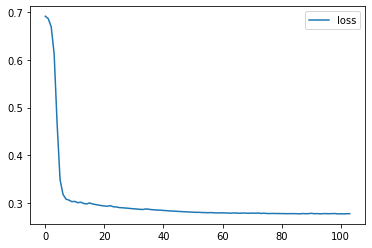

In [77]:
network_opt(N1_=5,N2_=5,min_nb_epochs_=100,max_nb_epochs_=3000,lr_=0.05,momentum_=0.1,stop=True)

N and M are: 1 1
no more changes: stopping !
[[44.  6.]
 [ 6. 44.]]
The number of errors: 12
The errors rate: 0.12
The value of cost: 0.31424614787101746
N and M are: 1 2
no more changes: stopping !
[[ 0. 50.]
 [ 0. 50.]]
The number of errors: 50
The errors rate: 0.5
The value of cost: 0.6934855580329895
N and M are: 1 3
no more changes: stopping !
[[43.  7.]
 [ 6. 44.]]
The number of errors: 13
The errors rate: 0.13
The value of cost: 0.2996980845928192
N and M are: 1 4
no more changes: stopping !
[[43.  7.]
 [ 6. 44.]]
The number of errors: 13
The errors rate: 0.13
The value of cost: 0.2996930778026581
N and M are: 1 5
no more changes: stopping !
[[46.  4.]
 [ 8. 42.]]
The number of errors: 12
The errors rate: 0.12
The value of cost: 0.3018838167190552
N and M are: 1 6
no more changes: stopping !
[[44.  6.]
 [ 6. 44.]]
The number of errors: 12
The errors rate: 0.12
The value of cost: 0.31130799651145935
N and M are: 1 7
no more changes: stopping !
[[44.  6.]
 [ 6. 44.]]
The number of

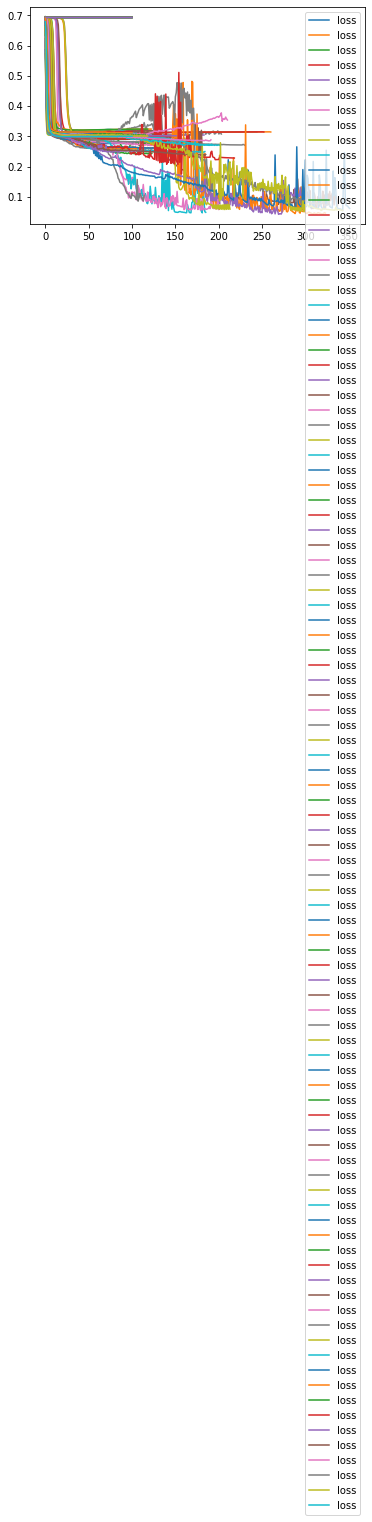

In [78]:
error_arr=[]
for i in range(1,11):
  for j in range(1,11):
    print("N and M are: {} {}".format(i,j))
    temp=network_opt(N1_=i,N2_=j,min_nb_epochs_=100,max_nb_epochs_=2000,lr_=0.05,momentum_=0.1,stop=True)
    print("The value of cost: {}".format(temp))
    error_arr.append(temp)

In [79]:
min(error_arr)

0.04559670761227608

In [80]:
np.argmin(error_arr)

51

In [81]:
print("The minimum error rate:{}, correspond to N1={} and N2={}".format(min(error_arr),((np.argmin(error_arr)//10)+1),((np.argmin(error_arr)%10)+1)))

The minimum error rate:0.04559670761227608, correspond to N1=6 and N2=2
